# Exploring the intuition behind the $R^2$ metric

**$R^2$ score (coefficient of determination) $\rightarrow$** measures how well a regression model performs compared to a simple mean baseline model. It can take on negative values when the model performs worse than a horizontal line (the mean of the target values).

$R^2 = 1.0 \rightarrow$ the model perfectly fits the data

$R^2 = 0.0 \rightarrow$ the model performs no better than a horizontal line (mean of target values)

$R^2 < 0.0 \rightarrow$ the model performs worse than a horizontal line, indicating that it does not explain the variance and is a poor fit for the data

--------------------------------------------------------------------------
**Mathematical explanation**: 

$ y = \text{true data, } \hat{y} = \text{predicted data, } \bar{y} = \text{mean of true data}$

$
\begin{align}
    R^2 &= 1 - \frac{SSR}{SST}
         = \frac{\text{distance between predicted and true data}}{\text{distance between true data and mean of true data}} \\
    &= \frac{\sum_{n=1}^{N} \left(\hat{y} - y\right)^2}{\sum_{n=1}^{N} \left(y - \bar{y}\right)^2}
\end{align}
$


In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# R2 function (based on equation above)
def get_R2(y_test, y_test_pred):
    y_mean = np.mean(y_test)
    ssr = np.sum((y_test_pred - y_test) ** 2)
    sst = np.sum((y_test - y_mean) ** 2)
    R2 = 1 - ssr / sst
    return R2,ssr,sst

def get_rho(y_test,y_test_pred):
    rho,_ = pearsonr(y_test.flatten(), y_test_pred.flatten())
    if np.isnan(rho):
        rho = 0.0
    return rho


## Toy data with simple linear regression

Using a set of toy data, I'll show three examples of potential $R^2$ values based on your model and data. 

**1. Positive $R^2$:** Using the weights from a simple linear regression model trained on a subset of data, you can predict the target test data better than if you had just guessed the mean of the true data.

*Congrats, your model has better prediction accuracy than if you had just lazily picked the data mean.*

**2. Zero $R^2$:** If the best fit line of the simple linear regression model trained on a subset of data is exactly the same as the mean of the true data, then your prediction of the target test data will be the same as the mean of the true data. You could also interpret this as relying soley on the labels of the training data, and completely ignoring the fitted linear regression model and your test input data.

*Your model doesn't totally suck, but it performs as well as if you had just picked the data mean.*

**3. Negative $R^2$:** Using the weights from a simple linear regression model trained on a subset of the data, your predictions of the target data are worse than if you had guessed the mean of the true data.

*Your model sucks super bad, you might have well just picked the data mean instead.*


/Users/kendranoneman/miniforge3/envs/neuraldecoding/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 1.0, '$R^2$ = -1.6, $\\rho$ = -0.5')

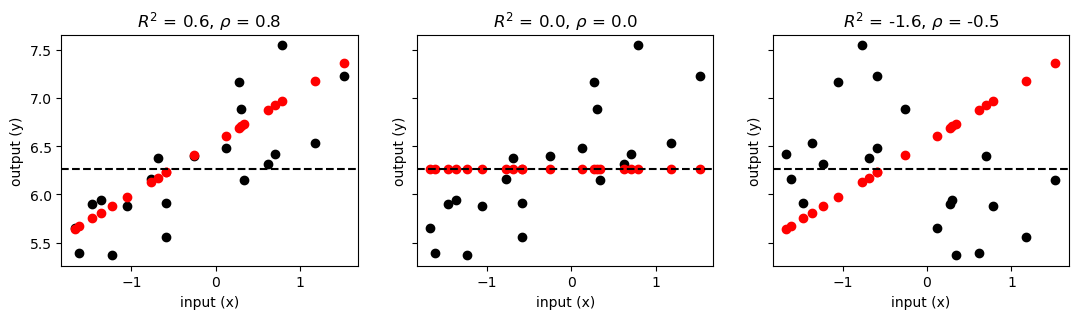

In [10]:
# Generate some random data
np.random.seed(0)
X = np.random.rand(100, 1)
y = 0.5 * X + 5 + np.random.rand(100, 1)*1.5 + 1.5 * X ** 2

# Split the data into training and testing sets
X_train, X_test = X[:80], X[80:]
y_train, y_test = y[:80], y[80:]

X_train_mean=np.nanmean(X_train) #Mean of training data
X_train_std=np.nanstd(X_train) #Stdev of training data
X_train=(X_train-X_train_mean)/X_train_std #Z-score training data
X_test=(X_test-X_train_mean)/X_train_std #Preprocess testing data in same manner as training data

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

#########################################################
fig, axs = plt.subplots(1, 3, figsize=(13, 3),sharey=True, sharex=True)

##### R^2 = normal #####
# Using the trained linear regression model, predict the y-labels for the left out X data
y_test_pred3 = model.predict(X_test)
R23,ssr3,sst3 = get_R2(y_test, y_test_pred3)
rho3 = get_rho(y_test, y_test_pred3)

i = 0
axs[i].scatter(X_test, y_test, color='black',label='true data')
axs[i].scatter(X_test, y_test_pred3, color='red', label='predicted data')
axs[i].axhline(np.mean(y_test), color='black', linestyle='--', label='mean of true data')
axs[i].set_xlabel('input (x)')
axs[i].set_ylabel('output (y)')
axs[i].set_title(f'$R^2$ = {R23:.1f}, $\\rho$ = {rho3:.1f}')


##### R^2 = zero #####
# Now what if you didn't use the linear regression model to make your predictions....
# But instead, just estimated that every input would result in the mean of the true data

y_test_pred2 = np.full_like(y_test_pred, np.mean(y_test)) 
R22,ssr2,sst2 = get_R2(y_test, y_test_pred2)
rho2 = get_rho(y_test, y_test_pred2)

i = 1
axs[i].scatter(X_test, y_test, color='black',label='true data')
axs[i].scatter(X_test, y_test_pred2, color='red', label='predicted data')
axs[i].axhline(np.mean(y_test), color='black', linestyle='--', label='mean of true data')
axs[i].set_xlabel('input (x)')
axs[i].set_ylabel('output (y)')
axs[i].set_title(f'$R^2$ = {R22:.1f}, $\\rho$ = {rho2:.1f}')

##### R^2 = shuffled #####
# Now what if you used the trained model, but the test data for predicting left out y-labels are shuffled
# So the mapping between the inputs and outputs is broken, and your prediction will be worse than if you had just guessed the mean of the true data
X_test1 = X_test
np.random.shuffle(X_test1)

y_test_pred1 = model.predict(X_test1)
R21,ssr1,ss1t = get_R2(y_test, y_test_pred1)
rho1 = get_rho(y_test, y_test_pred1)

i = 2
axs[i].scatter(X_test, y_test, color='black',label='true data')
axs[i].scatter(X_test, y_test_pred1, color='red', label='predicted data')
axs[i].axhline(np.mean(y_test), color='black', linestyle='--', label='mean of true data')
#axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[i].set_xlabel('input (x)')
axs[i].set_ylabel('output (y)')
axs[i].set_title(f'$R^2$ = {R21:.1f}, $\\rho$ = {rho1:.1f}')


When you shuffle the input test data during prediction, you are introducing randomness and breaking any structured relationship between the input features and the output. I'm doing this to establish a sort-of baseline or null hypothesis of model performance. The effect is more detrimental for more complex models like neural networks for the following reasons:

1. Complexity of Learned Patterns: Complex models like neural networks have the capacity to learn intricate and non-linear patterns in the data. They often capture high-dimensional relationships between features, which are highly dependent on the order and structure of the input data during training. When you shuffle the data, you disrupt these learned patterns, leading to poor predictions.

2. Overfitting: More complex models are prone to overfitting, where they memorize the training data rather than generalizing from it. Shuffling the data during testing exacerbates this issue, as the model may have memorized the training data's specific order and structure. When tested with shuffled data, the model's overfit patterns no longer apply.
